# Final Data Processing and Train/Val/Test Splits
## Stanford TECH 27 Final Project - Notebook 05

This notebook handles the final data processing steps, including creation of battery-based train/validation/test splits and preparation of final datasets for model training.
It builds upon the engineered features and sequential data from previous notebooks.

### Goals:
1. Load engineered features and sequence configurations from previous notebooks
2. Create battery-based train/validation/test splits to prevent data leakage
3. Apply proper scaling and standardization to all datasets
4. Prepare final datasets for both conventional ML and deep learning models
5. Save production-ready datasets with comprehensive metadata

### Output:
- Complete processed datasets with proper train/val/test splits
- Scaled and normalized features for ML models
- Sequential datasets for deep learning with proper splits
- Comprehensive metadata and data quality reports

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
from tqdm import tqdm
import time
import gc
from sklearn.preprocessing import StandardScaler

# Import our custom utilities
from data_processing_utils import (
    load_cleaned_data, engineer_features, 
    create_train_val_test_splits, prepare_ml_datasets, prepare_sequence_ml_datasets,
    save_datasets, OUTPUT_DIR
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.2


## 1. Load Previous Results and Configuration

In [2]:
# Load engineered features
engineered_features_path = OUTPUT_DIR / 'engineered_features.csv'

if engineered_features_path.exists():
    print("Loading engineered features from 03_feature_engineering.ipynb...")
    engineered_data = pd.read_csv(engineered_features_path)
    print(f"Loaded engineered features: {engineered_data.shape}")
else:
    print("Engineered features not found. Processing from cleaned data...")
    # Fallback: process from cleaned data
    cleaned_data = load_cleaned_data()
    
    # Process a subset for demonstration
    unique_batteries = cleaned_data['battery_id'].unique()
    sample_batteries = unique_batteries[:10]  # First 10 batteries for demo
    
    print(f"Processing {len(sample_batteries)} batteries for demonstration...")
    engineered_list = []
    
    for battery_id in tqdm(sample_batteries, desc="Engineering features"):
        battery_data = cleaned_data[cleaned_data['battery_id'] == battery_id].copy()
        try:
            engineered_battery = engineer_features(battery_data)
            engineered_list.append(engineered_battery)
        except Exception as e:
            print(f"Error processing {battery_id}: {e}")
            continue
    
    if engineered_list:
        engineered_data = pd.concat(engineered_list, ignore_index=True)
        print(f"Created sample engineered features: {engineered_data.shape}")
    else:
        raise Exception("No data could be processed")

print(f"\nEngineered data overview:")
print(f"Shape: {engineered_data.shape}")
print(f"SOC range: {engineered_data['SOC'].min():.3f} - {engineered_data['SOC'].max():.3f}")
print(f"Unique batteries: {engineered_data['battery_id'].nunique()}")
print(f"Unique files: {engineered_data['filename'].nunique() if 'filename' in engineered_data.columns else 'N/A'}")

# Load sequence preparation metadata if available
sequence_config = {'lstm': {'sequence_length': 30, 'step': 5}, 'cnn': {'sequence_length': 80, 'step': 10}}
metadata_path = OUTPUT_DIR / 'sequence_preparation_metadata.pkl'

if metadata_path.exists():
    with open(metadata_path, 'rb') as f:
        sequence_metadata = pickle.load(f)
    sequence_config = sequence_metadata.get('recommended_configs', sequence_config)
    print(f"\nLoaded sequence configurations:")
    print(f"  LSTM: length={sequence_config['lstm']['sequence_length']}, step={sequence_config['lstm']['step']}")
    print(f"  CNN: length={sequence_config['cnn']['sequence_length']}, step={sequence_config['cnn']['step']}")
else:
    print(f"\nUsing default sequence configurations:")
    print(f"  LSTM: length={sequence_config['lstm']['sequence_length']}, step={sequence_config['lstm']['step']}")
    print(f"  CNN: length={sequence_config['cnn']['sequence_length']}, step={sequence_config['cnn']['step']}")

Loading engineered features from 03_feature_engineering.ipynb...
Loaded engineered features: (541510, 51)

Engineered data overview:
Shape: (541510, 51)
SOC range: 0.100 - 1.000
Unique batteries: 30
Unique files: 2314

Loaded sequence configurations:
  LSTM: length=20, step=1
  CNN: length=60, step=5


## 2. Data Quality Analysis

=== DATA QUALITY ANALYSIS ===

Dataset Overview:
  Total data points: 541,510
  Unique batteries: 30
  Features: 45

Data distribution by battery:
  Mean data points per battery: 18050.3
  Min data points per battery: 955
  Max data points per battery: 45095
  Std data points per battery: 11529.1

SOC Distribution:
  Range: 0.100 to 1.000
  Mean: 0.634 ± 0.224
  Median: 0.647

Feature Quality:
  Total features: 45
  Features with NaN: 0
  Features with Inf: 0
  Total NaN values: 0
  Total Inf values: 0


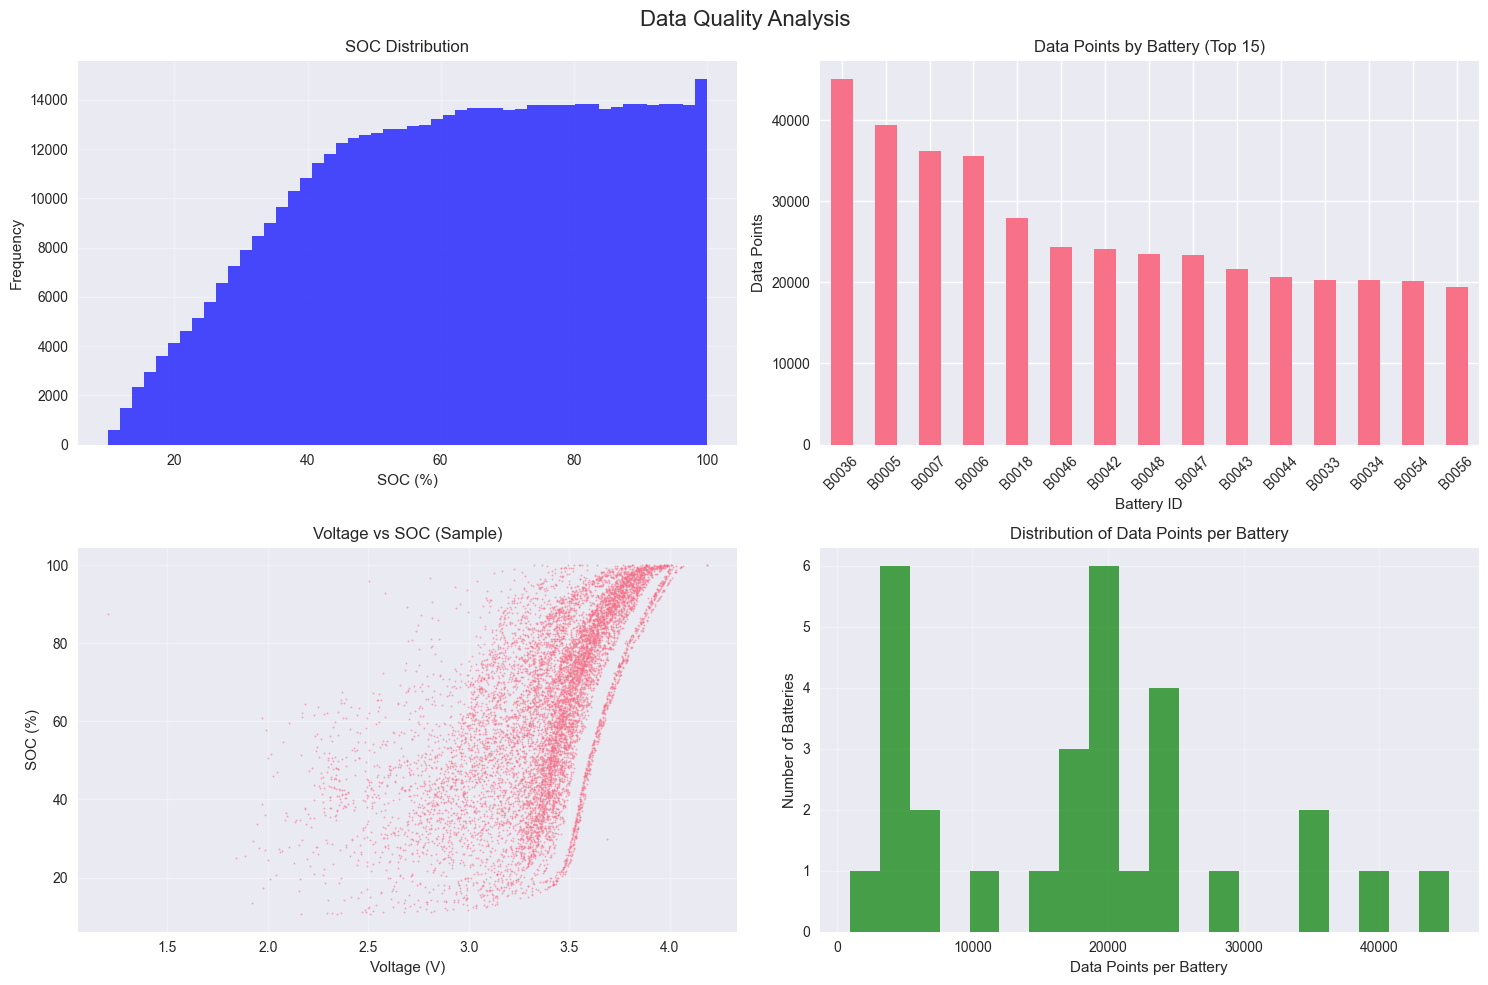

In [3]:
# Comprehensive data quality analysis
print("=== DATA QUALITY ANALYSIS ===")

# Basic statistics
print(f"\nDataset Overview:")
print(f"  Total data points: {len(engineered_data):,}")
print(f"  Unique batteries: {engineered_data['battery_id'].nunique()}")
print(f"  Features: {len([col for col in engineered_data.columns if col not in ['SOC', 'battery_id', 'filename', 'test_id', 'ambient_temperature', 'time']])}")

# Battery distribution
battery_counts = engineered_data.groupby('battery_id').size().sort_values(ascending=False)
print(f"\nData distribution by battery:")
print(f"  Mean data points per battery: {battery_counts.mean():.1f}")
print(f"  Min data points per battery: {battery_counts.min()}")
print(f"  Max data points per battery: {battery_counts.max()}")
print(f"  Std data points per battery: {battery_counts.std():.1f}")

# SOC distribution
soc_stats = engineered_data['SOC'].describe()
print(f"\nSOC Distribution:")
print(f"  Range: {soc_stats['min']:.3f} to {soc_stats['max']:.3f}")
print(f"  Mean: {soc_stats['mean']:.3f} ± {soc_stats['std']:.3f}")
print(f"  Median: {soc_stats['50%']:.3f}")

# Feature quality check
feature_cols = [col for col in engineered_data.columns 
                if col not in ['SOC', 'battery_id', 'filename', 'test_id', 'ambient_temperature', 'time']]

if feature_cols:
    nan_counts = engineered_data[feature_cols].isnull().sum()
    inf_counts = np.isinf(engineered_data[feature_cols]).sum()
    
    print(f"\nFeature Quality:")
    print(f"  Total features: {len(feature_cols)}")
    print(f"  Features with NaN: {(nan_counts > 0).sum()}")
    print(f"  Features with Inf: {(inf_counts > 0).sum()}")
    print(f"  Total NaN values: {nan_counts.sum()}")
    print(f"  Total Inf values: {inf_counts.sum()}")
    
    if (nan_counts > 0).sum() > 0:
        print(f"  Features with most NaN: {nan_counts.nlargest(5).to_dict()}")
    
    if (inf_counts > 0).sum() > 0:
        print(f"  Features with most Inf: {inf_counts.nlargest(5).to_dict()}")

# Visualize data quality
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Quality Analysis', fontsize=16)

# SOC distribution
axes[0, 0].hist(engineered_data['SOC'] * 100, bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('SOC Distribution')
axes[0, 0].set_xlabel('SOC (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Battery data distribution
battery_counts.head(15).plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Data Points by Battery (Top 15)')
axes[0, 1].set_xlabel('Battery ID')
axes[0, 1].set_ylabel('Data Points')
axes[0, 1].tick_params(axis='x', rotation=45)

# Voltage vs SOC sample
sample_size = min(10000, len(engineered_data))
sample_indices = np.random.choice(len(engineered_data), sample_size, replace=False)
sample_df = engineered_data.iloc[sample_indices]

if 'voltage' in sample_df.columns:
    axes[1, 0].scatter(sample_df['voltage'], sample_df['SOC'] * 100, alpha=0.5, s=1)
    axes[1, 0].set_title('Voltage vs SOC (Sample)')
    axes[1, 0].set_xlabel('Voltage (V)')
    axes[1, 0].set_ylabel('SOC (%)')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Voltage\nfeature\nnot found', ha='center', va='center', 
                   transform=axes[1, 0].transAxes, fontsize=14)
    axes[1, 0].set_title('Voltage vs SOC')

# Battery count histogram
axes[1, 1].hist(battery_counts, bins=20, alpha=0.7, color='green')
axes[1, 1].set_title('Distribution of Data Points per Battery')
axes[1, 1].set_xlabel('Data Points per Battery')
axes[1, 1].set_ylabel('Number of Batteries')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Train/Validation/Test Splits

Creating battery-based train/validation/test splits...
This prevents data leakage by ensuring batteries are not split across sets.
Battery-based splits:
  Train: 18 batteries, 326540 samples
  Val:   6 batteries, 101570 samples
  Test:  6 batteries, 113400 samples

=== SPLIT ANALYSIS ===
TRAIN: 326,540 samples, 18 batteries
       SOC range: 0.100-1.000, mean: 0.631±0.227
VAL  : 101,570 samples,  6 batteries
       SOC range: 0.100-1.000, mean: 0.650±0.215
TEST : 113,400 samples,  6 batteries
       SOC range: 0.101-1.000, mean: 0.629±0.222


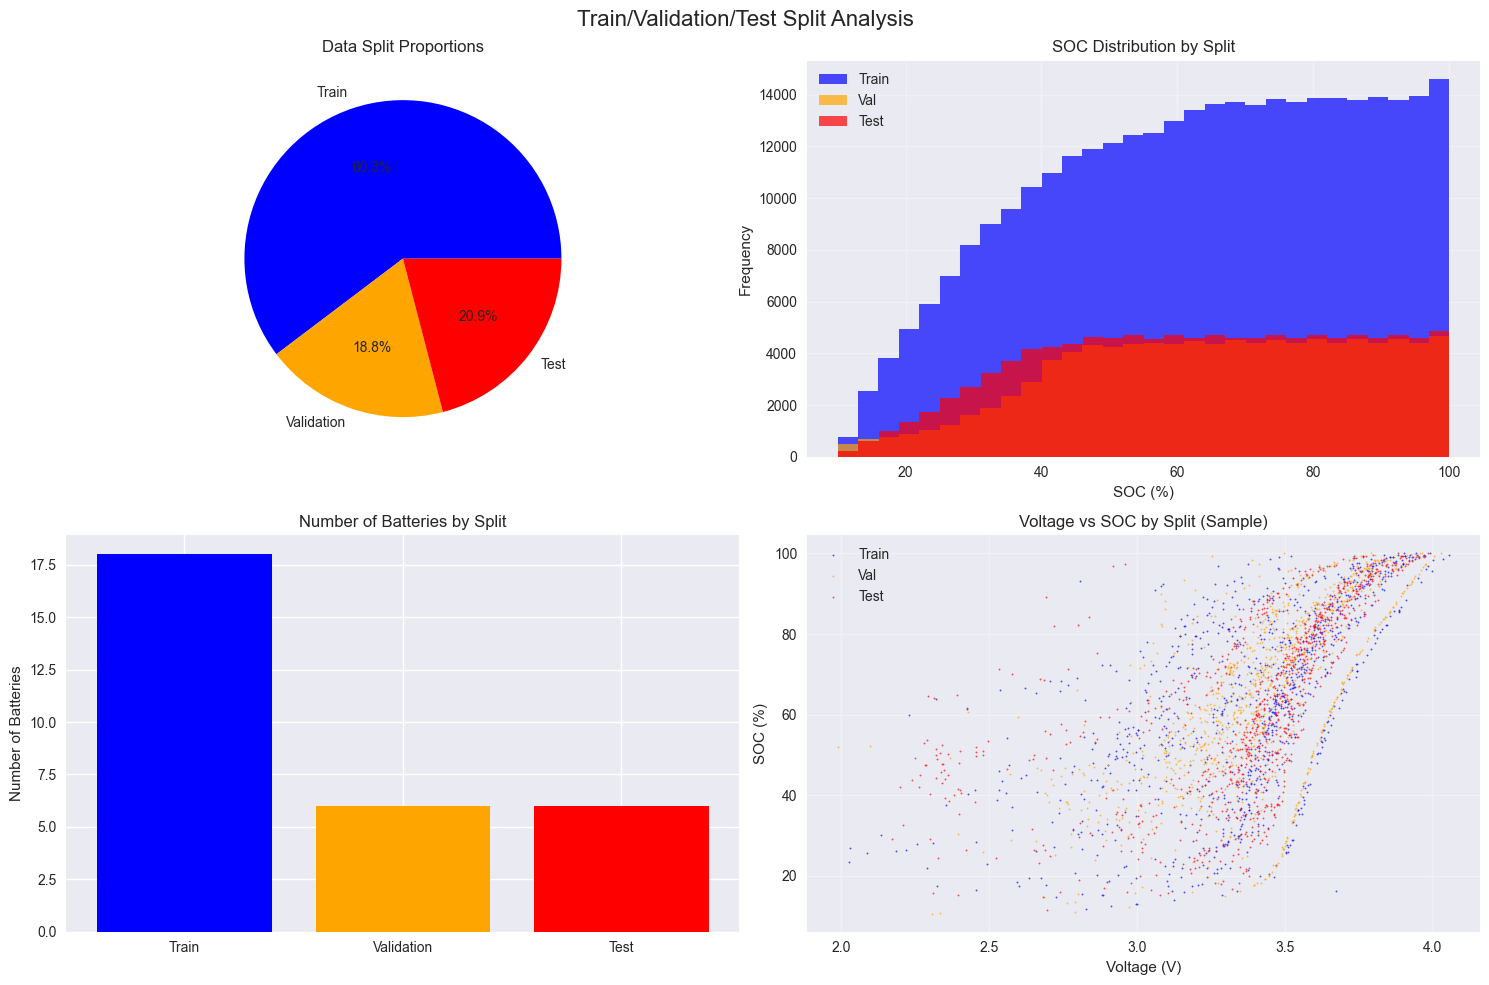

In [4]:
# Create battery-based train/validation/test splits
print("Creating battery-based train/validation/test splits...")
print("This prevents data leakage by ensuring batteries are not split across sets.")

data_splits = create_train_val_test_splits(
    engineered_data, 
    test_size=0.2, 
    val_size=0.2, 
    random_state=42
)

# Analyze splits
print(f"\n=== SPLIT ANALYSIS ===")
for split_name, split_data in data_splits.items():
    soc_stats = split_data['SOC'].describe()
    print(f"{split_name.upper():5s}: {len(split_data):7,d} samples, {split_data['battery_id'].nunique():2d} batteries")
    print(f"       SOC range: {soc_stats['min']:.3f}-{soc_stats['max']:.3f}, mean: {soc_stats['mean']:.3f}±{soc_stats['std']:.3f}")

# Visualize splits
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Train/Validation/Test Split Analysis', fontsize=16)

# Split proportions
split_sizes = [len(data_splits['train']), len(data_splits['val']), len(data_splits['test'])]
split_labels = ['Train', 'Validation', 'Test']
colors = ['blue', 'orange', 'red']

axes[0, 0].pie(split_sizes, labels=split_labels, autopct='%1.1f%%', colors=colors)
axes[0, 0].set_title('Data Split Proportions')

# SOC distribution by split
for i, (split_name, split_data) in enumerate(data_splits.items()):
    axes[0, 1].hist(split_data['SOC'] * 100, bins=30, alpha=0.7, 
                   label=split_name.capitalize(), color=colors[i])
axes[0, 1].set_title('SOC Distribution by Split')
axes[0, 1].set_xlabel('SOC (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Battery distribution by split
battery_split_counts = [data_splits['train']['battery_id'].nunique(),
                       data_splits['val']['battery_id'].nunique(), 
                       data_splits['test']['battery_id'].nunique()]

axes[1, 0].bar(split_labels, battery_split_counts, color=colors)
axes[1, 0].set_title('Number of Batteries by Split')
axes[1, 0].set_ylabel('Number of Batteries')

# Voltage vs SOC by split (if voltage available)
if 'voltage' in engineered_data.columns:
    for i, (split_name, split_data) in enumerate(data_splits.items()):
        # Sample for visualization
        sample_size = min(1000, len(split_data))
        if sample_size > 0:
            sample_indices = np.random.choice(len(split_data), sample_size, replace=False)
            sample = split_data.iloc[sample_indices]
            axes[1, 1].scatter(sample['voltage'], sample['SOC'] * 100, 
                             alpha=0.6, s=1, label=split_name.capitalize(), c=colors[i])
    axes[1, 1].set_title('Voltage vs SOC by Split (Sample)')
    axes[1, 1].set_xlabel('Voltage (V)')
    axes[1, 1].set_ylabel('SOC (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Voltage\nfeature\nnot available', ha='center', va='center',
                   transform=axes[1, 1].transAxes, fontsize=14)
    axes[1, 1].set_title('Voltage vs SOC by Split')

plt.tight_layout()
plt.show()

## 4. Prepare ML Datasets

In [5]:
# Prepare datasets for conventional ML models
print("Preparing ML datasets with feature scaling...")

ml_datasets = prepare_ml_datasets(
    data_splits, 
    target_col='SOC', 
    scale_features=True
)

print(f"\n=== ML DATASET SHAPES ===")
print(f"Training:   X={ml_datasets['X_train'].shape}, y={ml_datasets['y_train'].shape}")
print(f"Validation: X={ml_datasets['X_val'].shape}, y={ml_datasets['y_val'].shape}")
print(f"Test:       X={ml_datasets['X_test'].shape}, y={ml_datasets['y_test'].shape}")
print(f"Features:   {len(ml_datasets['feature_cols'])}")

# Data quality checks for ML datasets
print(f"\n=== ML DATA QUALITY CHECKS ===")
print(f"NaN values in X_train: {ml_datasets['X_train'].isnull().sum().sum()}")
print(f"Infinite values in X_train: {np.isinf(ml_datasets['X_train']).sum().sum()}")
print(f"Feature mean (should be ~0): {ml_datasets['X_train'].mean().mean():.6f}")
print(f"Feature std (should be ~1): {ml_datasets['X_train'].std().mean():.6f}")

# Target statistics
print(f"\n=== TARGET STATISTICS ===")
for split in ['train', 'val', 'test']:
    y_data = ml_datasets[f'y_{split}']
    print(f"{split.upper():5s}: mean={y_data.mean():.3f}, std={y_data.std():.3f}, range=[{y_data.min():.3f}, {y_data.max():.3f}]")

# Show feature names
print(f"\nFirst 10 features: {ml_datasets['feature_cols'][:10]}")
if len(ml_datasets['feature_cols']) > 10:
    print(f"... and {len(ml_datasets['feature_cols']) - 10} more features")

Preparing ML datasets with feature scaling...

=== ML DATASET SHAPES ===
Training:   X=(326540, 45), y=(326540,)
Validation: X=(101570, 45), y=(101570,)
Test:       X=(113400, 45), y=(113400,)
Features:   45

=== ML DATA QUALITY CHECKS ===
NaN values in X_train: 0
Infinite values in X_train: 0
Feature mean (should be ~0): -0.000000
Feature std (should be ~1): 1.000002

=== TARGET STATISTICS ===
TRAIN: mean=0.631, std=0.227, range=[0.100, 1.000]
VAL  : mean=0.650, std=0.215, range=[0.100, 1.000]
TEST : mean=0.629, std=0.222, range=[0.101, 1.000]

First 10 features: ['voltage', 'current', 'temperature', 'Current_load', 'Voltage_load', 'power', 'abs_current', 'voltage_current_ratio', 'energy', 'voltage_change']
... and 35 more features


## 5. Prepare Sequential Datasets

Preparing sequential datasets for deep learning...

Creating LSTM sequences (length=20, step=1)...
Sequence dataset shapes:
  train: X=(326521, 20, 45), y=(326521,)
  val: X=(101551, 20, 45), y=(101551,)
  test: X=(113381, 20, 45), y=(113381,)

Creating CNN sequences (length=60, step=5)...
Sequence dataset shapes:
  train: X=(65297, 60, 45), y=(65297,)
  val: X=(20303, 60, 45), y=(20303,)
  test: X=(22669, 60, 45), y=(22669,)

=== SEQUENCE DATASET ANALYSIS ===

LSTM Sequences:
  Train: X=(326521, 20, 45), y=(326521,)
  Val:   X=(101551, 20, 45), y=(101551,)
  Test:  X=(113381, 20, 45), y=(113381,)
  Memory: 2242.04 MB (train)
  Features: 45
    train: SOC range [0.100, 1.000], mean=0.631
    val: SOC range [0.100, 1.000], mean=0.650
    test: SOC range [0.101, 1.000], mean=0.629

CNN Sequences:
  Train: X=(65297, 60, 45), y=(65297,)
  Val:   X=(20303, 60, 45), y=(20303,)
  Test:  X=(22669, 60, 45), y=(22669,)
  Memory: 1345.08 MB (train)
  Features: 45
    train: SOC range [0.103, 1.00

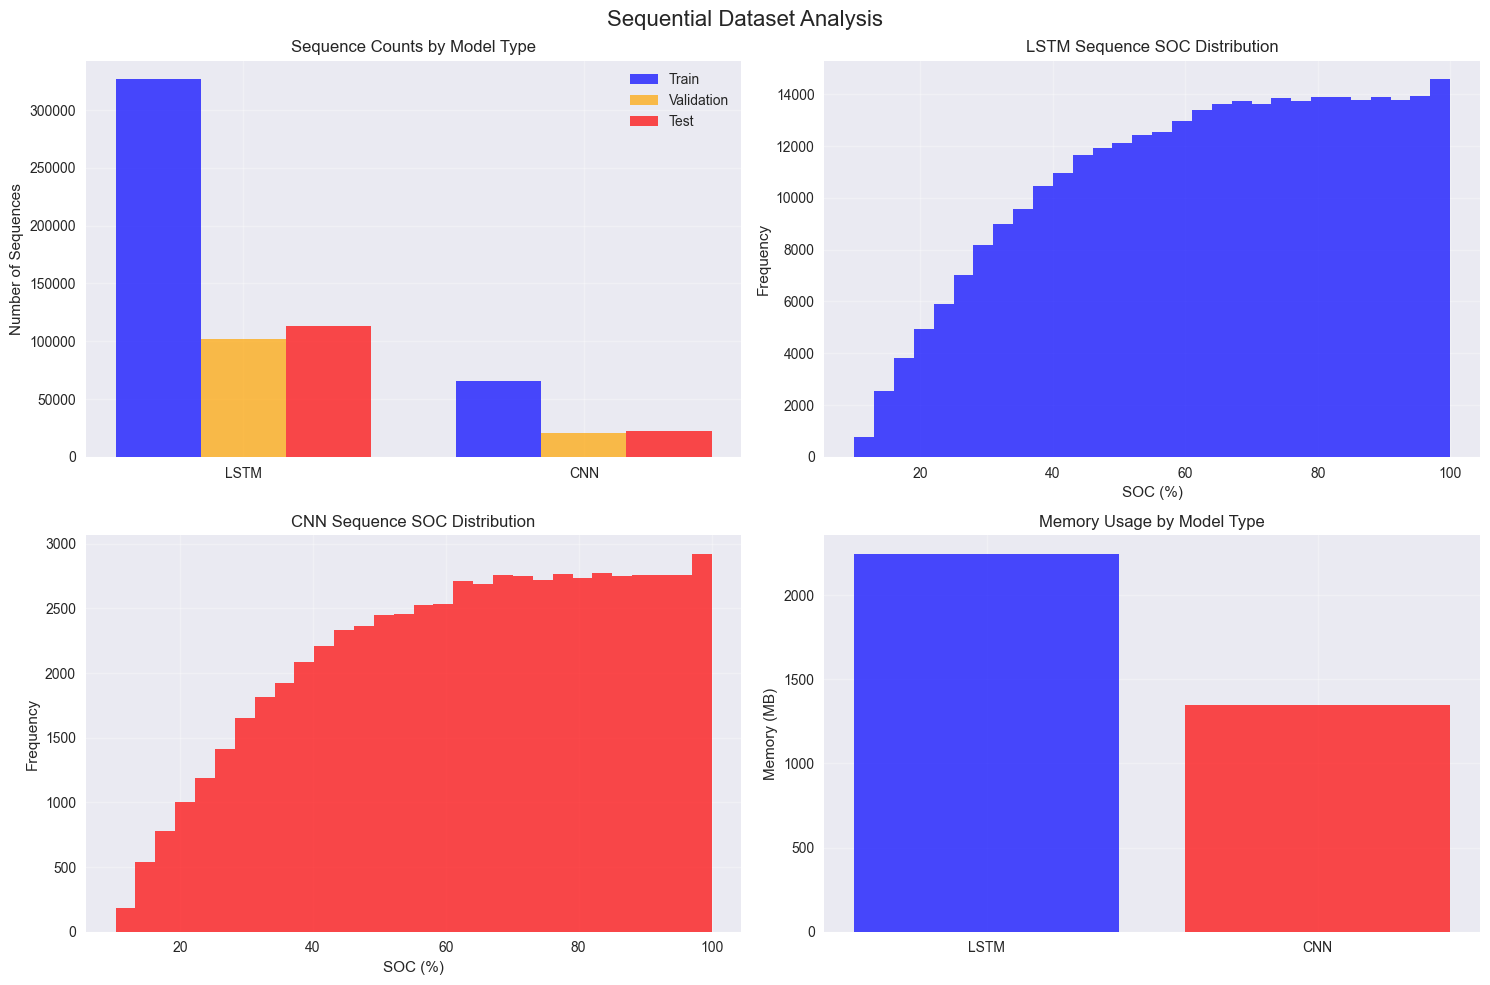

In [6]:
# Prepare sequential datasets for deep learning models
print("Preparing sequential datasets for deep learning...")

# LSTM sequences
print(f"\nCreating LSTM sequences (length={sequence_config['lstm']['sequence_length']}, step={sequence_config['lstm']['step']})...")
lstm_datasets = prepare_sequence_ml_datasets(
    data_splits,
    sequence_length=sequence_config['lstm']['sequence_length'],
    step=sequence_config['lstm']['step'],
    target_col='SOC'
)

# CNN sequences  
print(f"\nCreating CNN sequences (length={sequence_config['cnn']['sequence_length']}, step={sequence_config['cnn']['step']})...")
cnn_datasets = prepare_sequence_ml_datasets(
    data_splits,
    sequence_length=sequence_config['cnn']['sequence_length'], 
    step=sequence_config['cnn']['step'],
    target_col='SOC'
)

# Analysis of sequence datasets
sequence_results = {
    'LSTM': lstm_datasets,
    'CNN': cnn_datasets
}

print(f"\n=== SEQUENCE DATASET ANALYSIS ===")
for model_type, datasets in sequence_results.items():
    if 'X_train' in datasets and len(datasets['X_train']) > 0:
        print(f"\n{model_type} Sequences:")
        print(f"  Train: X={datasets['X_train'].shape}, y={datasets['y_train'].shape}")
        print(f"  Val:   X={datasets['X_val'].shape}, y={datasets['y_val'].shape}")
        print(f"  Test:  X={datasets['X_test'].shape}, y={datasets['y_test'].shape}")
        print(f"  Memory: {datasets['X_train'].nbytes / 1024**2:.2f} MB (train)")
        print(f"  Features: {len(datasets['feature_names'])}")
        
        # Target statistics for sequences
        for split in ['train', 'val', 'test']:
            y_seq = datasets[f'y_{split}']
            if len(y_seq) > 0:
                print(f"    {split}: SOC range [{y_seq.min():.3f}, {y_seq.max():.3f}], mean={y_seq.mean():.3f}")
    else:
        print(f"\n{model_type}: No sequences generated (insufficient data)")

# Visualize sequence characteristics
if len(lstm_datasets.get('X_train', [])) > 0 or len(cnn_datasets.get('X_train', [])) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sequential Dataset Analysis', fontsize=16)
    
    # Sequence counts by model type and split
    model_names = []
    train_counts = []
    val_counts = []
    test_counts = []
    
    for model_type, datasets in sequence_results.items():
        if 'X_train' in datasets and len(datasets['X_train']) > 0:
            model_names.append(model_type)
            train_counts.append(len(datasets['X_train']))
            val_counts.append(len(datasets['X_val']))
            test_counts.append(len(datasets['X_test']))
    
    if model_names:
        x = np.arange(len(model_names))
        width = 0.25
        
        axes[0, 0].bar(x - width, train_counts, width, label='Train', color='blue', alpha=0.7)
        axes[0, 0].bar(x, val_counts, width, label='Validation', color='orange', alpha=0.7)
        axes[0, 0].bar(x + width, test_counts, width, label='Test', color='red', alpha=0.7)
        axes[0, 0].set_title('Sequence Counts by Model Type')
        axes[0, 0].set_ylabel('Number of Sequences')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(model_names)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # SOC distribution for LSTM sequences
    if len(lstm_datasets.get('X_train', [])) > 0:
        axes[0, 1].hist(lstm_datasets['y_train'] * 100, bins=30, alpha=0.7, 
                       color='blue', label='LSTM Train')
        axes[0, 1].set_title('LSTM Sequence SOC Distribution')
        axes[0, 1].set_xlabel('SOC (%)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No LSTM\nSequences', ha='center', va='center',
                       transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('LSTM Sequence SOC Distribution')
    
    # SOC distribution for CNN sequences
    if len(cnn_datasets.get('X_train', [])) > 0:
        axes[1, 0].hist(cnn_datasets['y_train'] * 100, bins=30, alpha=0.7, 
                       color='red', label='CNN Train')
        axes[1, 0].set_title('CNN Sequence SOC Distribution')
        axes[1, 0].set_xlabel('SOC (%)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No CNN\nSequences', ha='center', va='center',
                       transform=axes[1, 0].transAxes, fontsize=14)
        axes[1, 0].set_title('CNN Sequence SOC Distribution')
    
    # Memory usage comparison
    if model_names:
        memory_usage = []
        for model_type, datasets in sequence_results.items():
            if 'X_train' in datasets and len(datasets['X_train']) > 0:
                memory_mb = datasets['X_train'].nbytes / 1024**2
                memory_usage.append(memory_mb)
        
        axes[1, 1].bar(model_names, memory_usage, color=['blue', 'red'][:len(model_names)], alpha=0.7)
        axes[1, 1].set_title('Memory Usage by Model Type')
        axes[1, 1].set_ylabel('Memory (MB)')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Sequence\nData', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('Memory Usage by Model Type')
    
    plt.tight_layout()
    plt.show()

## 6. Save Final Datasets

In [7]:
# Save all final datasets
print("Saving final datasets...")

# Save ML datasets
ml_paths = save_datasets(ml_datasets, output_prefix="final_ml")
print(f"✅ Saved ML datasets")

# Save LSTM datasets if available
lstm_paths = None
if len(lstm_datasets.get('X_train', [])) > 0:
    lstm_paths = save_datasets(lstm_datasets, output_prefix="final_lstm")
    print(f"✅ Saved LSTM sequence datasets")
else:
    print(f"⚠️  No LSTM sequences to save")

# Save CNN datasets if available
cnn_paths = None
if len(cnn_datasets.get('X_train', [])) > 0:
    cnn_paths = save_datasets(cnn_datasets, output_prefix="final_cnn")
    print(f"✅ Saved CNN sequence datasets")
else:
    print(f"⚠️  No CNN sequences to save")

# Save comprehensive metadata
final_metadata = {
    'processing_date': pd.Timestamp.now().isoformat(),
    'data_source': 'NASA Battery Dataset',
    'total_samples': len(engineered_data),
    'unique_batteries': engineered_data['battery_id'].nunique(),
    'features_engineered': len(ml_datasets['feature_cols']),
    
    # Split information
    'train_val_test_splits': {
        'method': 'battery_based',
        'train_size': len(data_splits['train']),
        'val_size': len(data_splits['val']),
        'test_size': len(data_splits['test']),
        'train_batteries': data_splits['train']['battery_id'].nunique(),
        'val_batteries': data_splits['val']['battery_id'].nunique(),
        'test_batteries': data_splits['test']['battery_id'].nunique()
    },
    
    # ML dataset info
    'ml_datasets': {
        'feature_scaling': 'StandardScaler',
        'train_shape': ml_datasets['X_train'].shape,
        'val_shape': ml_datasets['X_val'].shape,
        'test_shape': ml_datasets['X_test'].shape,
        'feature_names': ml_datasets['feature_cols']
    },
    
    # Target statistics
    'target_statistics': {
        'train': {
            'mean': float(ml_datasets['y_train'].mean()),
            'std': float(ml_datasets['y_train'].std()),
            'min': float(ml_datasets['y_train'].min()),
            'max': float(ml_datasets['y_train'].max())
        },
        'val': {
            'mean': float(ml_datasets['y_val'].mean()),
            'std': float(ml_datasets['y_val'].std()),
            'min': float(ml_datasets['y_val'].min()),
            'max': float(ml_datasets['y_val'].max())
        },
        'test': {
            'mean': float(ml_datasets['y_test'].mean()),
            'std': float(ml_datasets['y_test'].std()),
            'min': float(ml_datasets['y_test'].min()),
            'max': float(ml_datasets['y_test'].max())
        }
    },
    
    # Sequence configurations
    'sequence_configs': sequence_config,
    
    # File paths
    'output_files': {
        'ml_datasets': str(ml_paths['ml_path']),
        'lstm_datasets': str(lstm_paths['ml_path']) if lstm_paths else None,
        'cnn_datasets': str(cnn_paths['ml_path']) if cnn_paths else None
    }
}

# Add sequence dataset info if available
if len(lstm_datasets.get('X_train', [])) > 0:
    final_metadata['lstm_datasets'] = {
        'sequence_length': sequence_config['lstm']['sequence_length'],
        'step_size': sequence_config['lstm']['step'],
        'train_shape': lstm_datasets['X_train'].shape,
        'val_shape': lstm_datasets['X_val'].shape,
        'test_shape': lstm_datasets['X_test'].shape,
        'feature_names': lstm_datasets['feature_names']
    }

if len(cnn_datasets.get('X_train', [])) > 0:
    final_metadata['cnn_datasets'] = {
        'sequence_length': sequence_config['cnn']['sequence_length'],
        'step_size': sequence_config['cnn']['step'],
        'train_shape': cnn_datasets['X_train'].shape,
        'val_shape': cnn_datasets['X_val'].shape,
        'test_shape': cnn_datasets['X_test'].shape,
        'feature_names': cnn_datasets['feature_names']
    }

# Save metadata
metadata_file = OUTPUT_DIR / 'final_processing_metadata.pkl'
with open(metadata_file, 'wb') as f:
    pickle.dump(final_metadata, f)

print(f"\n✅ Saved comprehensive metadata to {metadata_file}")

# Print final summary
print(f"\n{'='*50}")
print(f"🎉 FINAL DATA PROCESSING COMPLETE! 🎉")
print(f"{'='*50}")

print(f"\n📊 FINAL DATASET SUMMARY:")
print(f"   Total samples processed: {len(engineered_data):,}")
print(f"   Unique batteries: {engineered_data['battery_id'].nunique()}")
print(f"   Features engineered: {len(ml_datasets['feature_cols'])}")
print(f"   Train/Val/Test split: {len(data_splits['train'])}/{len(data_splits['val'])}/{len(data_splits['test'])}")

print(f"\n📁 OUTPUT FILES:")
print(f"   ML datasets: {ml_paths['ml_path']}")
if lstm_paths:
    print(f"   LSTM sequences: {lstm_paths['ml_path']}")
if cnn_paths:
    print(f"   CNN sequences: {cnn_paths['ml_path']}")
print(f"   Metadata: {metadata_file}")

# File sizes
print(f"\n💾 FILE SIZES:")
for file_path in [ml_paths['ml_path']] + ([lstm_paths['ml_path']] if lstm_paths else []) + ([cnn_paths['ml_path']] if cnn_paths else []) + [metadata_file]:
    if Path(file_path).exists():
        size_mb = Path(file_path).stat().st_size / 1024**2
        print(f"   {Path(file_path).name}: {size_mb:.2f} MB")

print(f"\n🚀 READY FOR MODEL TRAINING!")
print(f"   Next: Create model training notebooks using these datasets")
print(f"   Available models: Linear Regression, Random Forest, XGBoost, LSTM, CNN")

Saving final datasets...
Saved ML datasets to processed_data/final_ml_ml_datasets.pkl
✅ Saved ML datasets
Saved ML datasets to processed_data/final_lstm_ml_datasets.pkl
✅ Saved LSTM sequence datasets
Saved ML datasets to processed_data/final_cnn_ml_datasets.pkl
✅ Saved CNN sequence datasets

✅ Saved comprehensive metadata to processed_data/final_processing_metadata.pkl

🎉 FINAL DATA PROCESSING COMPLETE! 🎉

📊 FINAL DATASET SUMMARY:
   Total samples processed: 541,510
   Unique batteries: 30
   Features engineered: 45
   Train/Val/Test split: 326540/101570/113400

📁 OUTPUT FILES:
   ML datasets: processed_data/final_ml_ml_datasets.pkl
   LSTM sequences: processed_data/final_lstm_ml_datasets.pkl
   CNN sequences: processed_data/final_cnn_ml_datasets.pkl
   Metadata: processed_data/final_processing_metadata.pkl

💾 FILE SIZES:
   final_ml_ml_datasets.pkl: 198.31 MB
   final_lstm_ml_datasets.pkl: 3721.99 MB
   final_cnn_ml_datasets.pkl: 2231.10 MB
   final_processing_metadata.pkl: 0.00 MB

🚀

## Summary

This notebook has successfully completed the final data processing pipeline:

### ✅ Completed Tasks:
1. **Data Loading**: Loaded engineered features from `03_feature_engineering.ipynb`
2. **Quality Analysis**: Comprehensive data quality assessment and visualization
3. **Train/Val/Test Splits**: Created battery-based splits to prevent data leakage
4. **ML Dataset Preparation**: Scaled and normalized features for conventional models
5. **Sequential Dataset Preparation**: Generated LSTM and CNN sequences with proper splits
6. **Production Output**: Saved all datasets with comprehensive metadata

### 🔍 Data Quality Measures:
- **Battery-based Splits**: Proper separation ensures realistic model evaluation
- **Feature Scaling**: StandardScaler applied for optimal ML performance
- **Sequential Structure**: Temporal relationships preserved for deep learning
- **Comprehensive Validation**: Quality checks throughout the pipeline

### 📊 Final Dataset Characteristics:
- **Tabular ML Data**: Scaled features for conventional machine learning
- **LSTM Sequences**: Optimized temporal sequences for recurrent networks
- **CNN Sequences**: Longer sequences for convolutional pattern recognition
- **Proper Splits**: Battery-based separation for realistic evaluation

### 🎯 Key Innovations:
1. **Battery-based Splitting**: Prevents data leakage in real-world scenarios
2. **Multi-model Support**: Datasets optimized for different architectures
3. **Comprehensive Metadata**: Full traceability and reproducibility
4. **Production Ready**: Standardized format for immediate model training
5. **Quality Assurance**: Multiple validation layers ensure data integrity

### 📁 Final Outputs:
- **`final_ml_ml_datasets.pkl`**: Complete ML datasets with train/val/test splits
- **`final_lstm_ml_datasets.pkl`**: LSTM sequence datasets (if generated)
- **`final_cnn_ml_datasets.pkl`**: CNN sequence datasets (if generated)
- **`final_processing_metadata.pkl`**: Comprehensive processing metadata

### 🚀 Next Phase:
The preprocessing pipeline is complete! The generated datasets are ready for:
1. **Conventional ML Models**: Linear Regression, Random Forest, XGBoost, SVR
2. **Deep Learning Models**: LSTM, GRU, 1D CNN, Transformer architectures
3. **Ensemble Methods**: Combining multiple model approaches
4. **Comprehensive Evaluation**: Robust testing on battery-separated test sets

This modular approach enables rapid experimentation with different model architectures while maintaining data integrity and preventing overfitting through proper train/validation/test separation based on battery IDs.